In [1]:
%matplotlib inline


import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score

import seaborn as sns
from math import sqrt

In [2]:
training_df = pd.read_csv("MLResources/realestate_all_train.csv")
training_df.head()
training_df.count()

County    1188
State     1188
Year      1188
Price     1143
dtype: int64

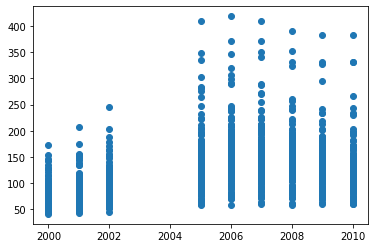

In [3]:
plt.plot(training_df['Year'], training_df['Price'],'o')


/anaconda3/envs/PythonData/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/envs/PythonData/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1., 0., 0., ..., 0., 0., 1.]),
 array([ 40.91666667,  41.10468491,  41.29270315, ..., 418.45729685,
        418.64531509, 418.83333333]),
 <a list of 2010 Patch objects>)

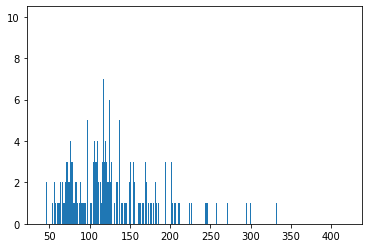

In [4]:
plt.hist(training_df['Price'], 2010)

In [5]:
missing_df = training_df.loc[training_df['Year'].isin(['2003','2004'])]

missing_df.head()  

,County,State,Year,Price


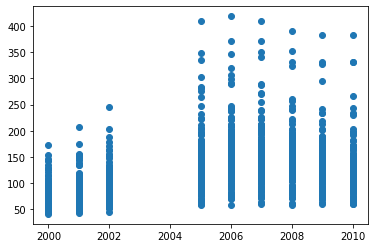

In [6]:
plt.plot(training_df['Year'], training_df['Price'],'o')


In [7]:
backfill_2002_df = training_df.loc[training_df['Year'].isin(['2002'])]
backfill_2005_df = training_df.loc[training_df['Year'].isin(['2005'])]
backfill_2002_df = backfill_2002_df.dropna()
backfill_2005_df = backfill_2005_df.dropna()
backfill_2002_df.count()
backfill_2005_df.count()

County    128
State     128
Year      128
Price     128
dtype: int64

In [8]:
backfill_df = backfill_2002_df.merge(backfill_2005_df, on=['County','State'], how='inner')
backfill_df.head()
# backfill_df.count()

,County,State,Year_x,Price_x,Year_y,Price_y
0,King County,WA,2002,154.750000,2005,202.750000
1,Fairfax County,VA,2002,178.583333,2005,302.750000
2,Montgomery County,MD,2002,170.083333,2005,282.000000
3,Prince Georges County,MD,2002,108.583333,2005,194.166667
4,Baltimore County,MD,2002,99.250000,2005,163.666667


In [9]:
backfill_df['Diff_Price'] = backfill_df['Price_y'] - backfill_df['Price_x']

backfill_df.head()

,County,State,Year_x,Price_x,Year_y,Price_y,Diff_Price
0,King County,WA,2002,154.750000,2005,202.750000,48.000000
1,Fairfax County,VA,2002,178.583333,2005,302.750000,124.166667
2,Montgomery County,MD,2002,170.083333,2005,282.000000,111.916667
3,Prince Georges County,MD,2002,108.583333,2005,194.166667,85.583333
4,Baltimore County,MD,2002,99.250000,2005,163.666667,64.416667


In [10]:
backfill_df['2003_Price'] = backfill_df['Diff_Price']/3 + backfill_df['Price_x']
backfill_df.head()

,County,State,Year_x,Price_x,Year_y,Price_y,Diff_Price,2003_Price
0,King County,WA,2002,154.750000,2005,202.750000,48.000000,170.750000
1,Fairfax County,VA,2002,178.583333,2005,302.750000,124.166667,219.972222
2,Montgomery County,MD,2002,170.083333,2005,282.000000,111.916667,207.388889
3,Prince Georges County,MD,2002,108.583333,2005,194.166667,85.583333,137.111111
4,Baltimore County,MD,2002,99.250000,2005,163.666667,64.416667,120.722222


In [11]:
backfill_df['2004_Price'] = backfill_df['Price_y'] - backfill_df['Diff_Price']/3 
backfill_df.head()

,County,State,Year_x,Price_x,Year_y,Price_y,Diff_Price,2003_Price,2004_Price
0,King County,WA,2002,154.750000,2005,202.750000,48.000000,170.750000,186.750000
1,Fairfax County,VA,2002,178.583333,2005,302.750000,124.166667,219.972222,261.361111
2,Montgomery County,MD,2002,170.083333,2005,282.000000,111.916667,207.388889,244.694444
3,Prince Georges County,MD,2002,108.583333,2005,194.166667,85.583333,137.111111,165.638889
4,Baltimore County,MD,2002,99.250000,2005,163.666667,64.416667,120.722222,142.194444


In [12]:
backfill_2003 = backfill_df.loc[:, ['County','State','Year','2003_Price']]
backfill_2003['Year'] = 2003
backfill_2003 = backfill_2003.rename(columns = {'2003_Price': 'Price'})
backfill_2003.head()

/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,County,State,Year,Price
0,King County,WA,2003,170.750000
1,Fairfax County,VA,2003,219.972222
2,Montgomery County,MD,2003,207.388889
3,Prince Georges County,MD,2003,137.111111
4,Baltimore County,MD,2003,120.722222


In [13]:
backfill_2004 = backfill_df.loc[:, ['County','State','Year','2004_Price']]
backfill_2004['Year'] = 2004
backfill_2004 = backfill_2004.rename(columns = {'2004_Price': 'Price'})
backfill_2004.head()

,County,State,Year,Price
0,King County,WA,2004,186.750000
1,Fairfax County,VA,2004,261.361111
2,Montgomery County,MD,2004,244.694444
3,Prince Georges County,MD,2004,165.638889
4,Baltimore County,MD,2004,142.194444


In [14]:
training_df = training_df.append(backfill_2003, ignore_index=True)
training_df = training_df.append(backfill_2004, ignore_index=True)
training_df

,County,State,Year,Price
0,King County,WA,2000,141.166667
1,Fairfax County,VA,2000,134.000000
2,Montgomery County,MD,2000,126.916667
3,Prince Georges County,MD,2000,91.833333
4,Baltimore County,MD,2000,86.750000
5,Pierce County,WA,2000,98.416667
6,Snohomish County,WA,2000,127.500000
7,Baltimore City,MD,2000,52.833333
8,District of Columbia,DC,2000,128.833333
9,Anne Arundel County,MD,2000,106.083333


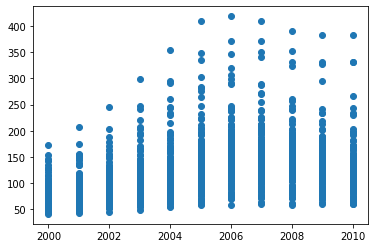

In [15]:
plt.plot(training_df['Year'], training_df['Price'],'o')

In [16]:
print(training_df.loc[training_df['Price'].isin(['NaN'])])

                   County State  Year  Price
68           Henry County    VA  2000    NaN
73         Whitman County    WA  2000    NaN
104         Hopewell City    VA  2000    NaN
119      Alleghany County    VA  2000    NaN
120   King William County    VA  2000    NaN
124    Manassas Park City    VA  2000    NaN
130      Middlesex County    VA  2000    NaN
131          Ferry County    WA  2000    NaN
200          Henry County    VA  2001    NaN
205        Whitman County    WA  2001    NaN
236         Hopewell City    VA  2001    NaN
251      Alleghany County    VA  2001    NaN
252   King William County    VA  2001    NaN
256    Manassas Park City    VA  2001    NaN
262      Middlesex County    VA  2001    NaN
263          Ferry County    WA  2001    NaN
332          Henry County    VA  2002    NaN
337        Whitman County    WA  2002    NaN
368         Hopewell City    VA  2002    NaN
383      Alleghany County    VA  2002    NaN
384   King William County    VA  2002    NaN
388    Man

In [17]:
training_dfdum = training_df.dropna()
training_dfdum.head()
training_dfdum.count()

County    1391
State     1391
Year      1391
Price     1391
dtype: int64

In [18]:
print(training_dfdum.loc[training_dfdum['Price'].isin(['NaN'])])

Empty DataFrame
Columns: [County, State, Year, Price]
Index: []


In [19]:
cat_features = ['County']
num_features = ['Price','Year']

categories = cat_features[0:len(cat_features)]

In [20]:
training_dfdum['County'].unique()

array(['King County', 'Fairfax County', 'Montgomery County',
       'Prince Georges County', 'Baltimore County', 'Pierce County',
       'Snohomish County', 'Baltimore City', 'District of Columbia',
       'Anne Arundel County', 'Spokane County', 'Virginia Beach City',
       'Clark County', 'Prince William County', 'Chesterfield County',
       'Loudoun County', 'Henrico County', 'Howard County',
       'Thurston County', 'Kitsap County', 'Harford County',
       'Yakima County', 'Norfolk City', 'Frederick County',
       'Chesapeake City', 'Arlington County', 'Richmond City',
       'Whatcom County', 'Newport News City', 'Benton County',
       'Carroll County', 'Washington County', 'Charles County',
       'Hampton City', 'Stafford County', 'Spotsylvania County',
       'Skagit County', 'Saint Marys County', 'Cowlitz County',
       'Cecil County', 'Hanover County', 'Wicomico County',
       'Roanoke City', 'Portsmouth City', 'Roanoke County',
       'Grant County', 'Calvert County'

In [ ]:
for category in categories:
    series = training_dfdum[category]
    dummies = pd.get_dummies(series, prefix=category)
    training_dfdum = pd.concat([training_dfdum, dummies], axis=1)
    
print(training_dfdum.columns)
training_dfdum.head(20)

In [22]:
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# print(labelencoder.fit_transform(training_dfdum['County']))

[63 34 76 ... 35 87 32]


In [24]:
# from sklearn.preprocessing import OneHotEncoder
# onehotencoder = OneHotEncoder(categorical_features = [0])
# x = onehotencoder.fit_transform(x).toarray()

In [ ]:
# from sklearn.preprocessing import Imputer
# imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
# imputer = imputer.fit(X[:, 1:3])
# X[:, 1:3] = imputer.transform(X[:, 1:3])

In [ ]:
from sklearn.preprocessing import StandardScaler
standardScalerX = StandardScaler()
x = standardScalerX.fit_transform(x)

In [ ]:
train_coefficients = []
train_intercepts = []

regr = linear_model.LinearRegression()

for county in training_dfdum['County'].unique():
    
    if county != 'Alleghany County' and county != 'Manassas Park City' and county != 'Ferry County':
        
        X_train = training_dfdum.loc[training_dfdum['County'].isin([county]), ['Year','County_'+county]]
                
#         X_train = np.asarray(X_train.values)
#         X_train = X_train.reshape(-1, 1)

        y_train = training_dfdum.loc[training_dfdum['County'].isin([county]), 'Price']
#         y_train = np.asarray(y_train.values)
#         y_train = y_train.reshape(-1, 1)

        lr_model = regr.fit(X_train, y_train)

        train_coefficients.append(lr_model.coef_) 
        train_intercepts.append(lr_model.intercept_)

    #     print('Weight coefficients: ', lr_model.coef_)
    #     print('y-axis intercept: ', lr_model.intercept_) 

    #     plt.scatter(X_train, y_train)
    #     plt.show()

        print('County:{0}'.format(county))
        print('X_train:{0}'.format(X_train))
        print('y_train:{0}'.format(y_train))

# print(train_coefficients)

# print(train_intercepts)


# mx + b = y




In [ ]:
y_train_predict = lr_model.predict(X_train)
print(f"True output: {y_train}")
print(f"Predicted output: {y_train_predict[0]}")
print(f"Prediction Error: {y_train_predict[0]-y_train[0]}")

# plt.scatter(X_train, y_train_predict)

In [ ]:
lr_r2 =  r2_score(y_train, y_train_predict)

In [ ]:
bx=plt.subplots(figsize=(12,8))
bx= sns.barplot(x=0, y=1, data=pd.DataFrame(zip(X_train, lr_model.coef_)))
plt.xticks(rotation='vertical')
plt.xlabel("Model Coefficient Types")
plt.ylabel("Model Coefficient Values")
plt.show()
print ("R squared: ", lr_r2)
print ("Average Coefficients: ", abs(lr_model.coef_).mean())
print ("Root Mean Squared Error: ", sqrt(mean_squared_error(y_train, y_train_predict)))
ax = sns.regplot(y_train, y_train_predict)

In [ ]:
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_predict)
# test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
# print('The test accuracy is', test_accuracy)